# CMPUT 466/566, Winter 2020 Introduction to Machine learning 
## Coding Assignment 2 
### Problem 1 Report
By Nathan Klapstein #1449872

In [16]:

import struct

import numpy as np

import matplotlib.pyplot as plt
import scipy
from matplotlib.colors import ListedColormap
from scipy.special import expit


In [17]:
def readMNISTdata():
    with open('data/t10k-images-idx3-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        test_data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        test_data = test_data.reshape((size, nrows * ncols))

    with open('data/t10k-labels-idx1-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        test_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        test_labels = test_labels.reshape((size, 1))

    with open('data/train-images-idx3-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        train_data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        train_data = train_data.reshape((size, nrows * ncols))

    with open('data/train-labels-idx1-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        train_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        train_labels = train_labels.reshape((size, 1))

    # augmenting a constant feature of 1 (absorbing the bias term)
    train_data = np.concatenate(
        (np.ones([train_data.shape[0], 1]), train_data), axis=1)
    test_data = np.concatenate((np.ones([test_data.shape[0], 1]), test_data),
                               axis=1)
    np.random.seed(314)
    np.random.shuffle(train_labels)
    np.random.seed(314)
    np.random.shuffle(train_data)

    X_train = train_data[:50000] / 256
    t_train = train_labels[:50000]

    X_val = train_data[50000:] / 256
    t_val = train_labels[50000:]

    return X_train, t_train, X_val, t_val, test_data, test_labels


Load in the MNIST data for later compute.

In [18]:
 X_train, t_train, X_val, t_val, X_test, t_test = readMNISTdata()

Gradient decent computation.

Recycled and fixed from CMPUT 466 Coding Assignment 1.

In [19]:
def gradient(X, w, y=None):
    # TODO: FIXED:  Did not scale gradient by 1/M;
    # TODO: CHECK: 1/M  this is 1/N_train or should be 1/X.shape[0]=1/batch_size
    return (1/X.shape[0])*np.matmul(np.transpose(X), (np.matmul(X, w) - y))


Various global configurations.

In [35]:
N_class = 10
alpha = 0.4  # learning rate
batch_size = 1000000  # batch size
MaxIter = 50  # Maximum iteration
decay = 0.  # weight decay

Mini-batch linear gradient decent.

Recycled and fixed from CMPUT 466 Coding assignment 1.

In [44]:
# def computeLoss(self, x, yMatrix):
#    """
#    It calculates a cross-entropy loss with regularization loss and gradient to update the weights.
#    :param x: An input sample
#    :param yMatrix: Label as one-hot encoding
#    :return:
#    """
#    numOfSamples = x.shape[0]
#    scores = np.dot(x, self.wt)
#    prob = self.softmaxEquation(scores)
# 
#    loss = -np.log(np.max(prob)) * yMatrix
#    regLoss = (1/2)*self.regStrength*np.sum(self.wt*self.wt)
#    totalLoss = (np.sum(loss) / numOfSamples) + regLoss
#    grad = ((-1 / numOfSamples) * np.dot(x.T, (yMatrix - prob))) + (self.regStrength * self.wt)
#    return totalLoss, grad

def softmaxEquation(scores):
    """
    It calculates a softmax probability
    :param scores: A matrix(wt * input sample)
    :return: softmax probability
    """
    scores -= np.max(scores)
    prob = (np.exp(scores).T / np.sum(np.exp(scores), axis=1)).T
    return prob

# 
# def meanAccuracy(self, x, y):
#     """
#     It calculates mean-per class accuracy
#     :param x: Input sample
#     :param y: label sample
#     :return: mean-per class accuracy
#     """
#     predY = predict(x)
#     predY = predY.reshape((-1, 1))  # convert to column vector
#     return np.mean(np.equal(y, predY))
# 


def oneHotIt(Y):
    m = Y.shape[0]
    Y = Y[:,0]
    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m)))))
    OHX = np.array(OHX.todense()).T
    return OHX


def softmax(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm


def getLoss(w,x,y,lam):
    m = x.shape[0] #First we get the number of training examples
    y_mat = oneHotIt(y) #Next we convert the integer class coding into a one-hot representation
    scores = np.dot(x,w) #Then we compute raw class scores given our input and current weights
    prob = softmax(scores) #Next we perform a softmax on these scores to get their probabilities
    loss = (-1 / m) * np.sum(y_mat * np.log(prob)) + (lam/2)*np.sum(w*w) #We then find the loss of the probabilities
    # print(x.shape)
    # print(y.shape)
    # print(y_mat.shape)
    # print(y_mat)
    # print(prob.shape)
    print(y_mat[0])
    print(prob[0])
    print(np.sum(prob[0]))
    # print(w.shape)
    grad = (-1 / m) * np.dot(x.T, (y_mat - prob)) + lam*w #And compute the gradient for that loss
    # print(grad.shape)
    return loss, grad





def getProbsAndPreds(someX, w):
    probs = softmax(np.dot(someX, w))
    preds = np.argmax(probs,axis=1)
    return probs,preds


# inspired by https://medium.com/@awjuliani/simple-softmax-in-python-tutorial-d6b4c4ed5c16
# https://www.w3resource.com/numpy/manipulation/ndarray-flatten.php
def getAccuracy(someX,someY,w):
    prob,prede = getProbsAndPreds(someX,w)
    someY = someY.flatten()
    # print(prede, someY)
    # print(prede.shape, someY.shape)
    num_correct = np.sum(prede == someY)
    num_incorrect = np.sum(prede != someY)
    # print(num_correct)
    # print(num_incorrect)
    accuracy = num_correct/(num_correct+num_incorrect)
    return accuracy


def predict(X, W, t=None):
    # X_new: Nsample x (d+1)
    # W: (d+1) x K
    
    reg = 0.001
    # TODO Your code here
    y = np.matmul(X, W)
    
    # y = np.argmax(X.dot(W), 1)
    t_hat = np.argmax(y, axis=1)
    num_of_samples = X.shape[0]

    z = np.dot(X, W)
    z -= np.max(z, axis=0)  # Max trick for the softmax, preventing infinite values
    y_prob = np.exp(z) / np.sum(np.exp(z)) 
    # ~z_i = z_i - z_max_i
    # exp_z = np.exp(z - np.max(z, axis=0) + np.min(z, axis=0))
    # p = exp_z / np.sum(exp_z, axis=0) # softmax 
    # p = softmaxEquation(z)
     
    # compute the loss
    loss = -np.log(np.max(y_prob)) * t
    reg_loss = 0.5  * reg * np.sum(np.multiply(W, W))  # Regularization term
    cross_entropy_loss =  (1 / num_of_samples) * (np.sum(loss)) 
    total_loss = cross_entropy_loss + reg_loss
    # total_loss = cross_entropy_loss
    
    # compute the mean-per class accuracy
    acc = getAccuracy(X, t, W)
    
    # Calculation of dW (gradient)
    grad = ((-1 / num_of_samples) * np.dot(X.T, (t - y_prob))) + (reg * W)
    
    
    return y, t_hat, total_loss, acc, grad



def train(X_train, t_train, X_val, t_val):
    N_train = X_train.shape[0]
    N_val = X_val.shape[0]

    # TODO Your code here
    
    # initialization
    w = np.zeros([X_train.shape[1], N_class])
    # w: (d+1)x1

    losses_train = []
    acc_val = []
    w_best = None
    acc_best = 0
    epoch_best = 0
    
    # TODO: figure this shit out
    lam = 0.4


    for epoch in range(MaxIter):
        loss_this_epoch = 0
        for b in range(int(np.ceil(N_train / batch_size))):
            X_batch = X_train[b * batch_size: (b + 1) * batch_size]
            t_batch = t_train[b * batch_size: (b + 1) * batch_size]
            loss_batch, grad = getLoss(w, X_batch, t_batch, lam)
            loss_this_epoch += loss_batch
            # TODO: grad is wrong shape (785,10) when it should be (785,1)
            if b ==5:
                return
            w = w - (alpha * grad)
            # y_hat_batch, t_hat, loss_batch, acc, grad = predict(X_batch, w, t_batch)
            # # print(loss_batch)
            # loss_this_epoch += loss_batch
            # # TODO: Your code here
            # # Mini-batch gradient descent
            # #TODO: FIX: scale gradient with 1/M
            # # w = w - alpha * gradient(X_batch, w, y_hat_batch)
            # w -= alpha * grad
   
        # TODO: Your code here
        # monitor model behavior after each epoch
        
        # 1. Compute the training loss by averaging loss_this_epoch
        #         losses_train.append(loss_this_epoch/int(np.ceil(N_train/batch_size)))
        
    
        loss_this_epoch = loss_this_epoch / (int(np.ceil(batch_size)))
        val_acc = getAccuracy(X_val, t_val, w)
        print(f"epoch {epoch}/{MaxIter} loss: {loss_this_epoch} val_acc:{val_acc}")
        
        # test_acc = getAccuracy(X_train, t_train, w)
        # print(f"est_acc:{test_acc} val_acc:{val_acc}")
        losses_train.append(loss_this_epoch)
        #print(f"epoch={epoch} training loss={loss_this_epoch/  (int(np.ceil(N_train/batch_size)))}")

        # 2. Perform validation on the validation test by the risk
        # risk_this_epoch = 0
        # for c in range(int(np.ceil(N_val / batch_size))):
        #     X_val_batch = X_val[c * batch_size: (c + 1) * batch_size]
        #     y_val_batch = y_val[c * batch_size: (c + 1) * batch_size]
        #     _, _, risk = predict(X_val_batch, w, y_val_batch)
        #     risk_this_epoch += risk
        # TODO: FIXED: Validation set should not be run in batches
        # y, t_hat, _, acc, grad = predict(X_val, w, t_val)
        acc_val.append(val_acc)
        
        # 3. Keep track of the best validation epoch, risk, and the weights
        if acc_val[epoch] >= acc_best:
            epoch_best = epoch
            acc_best = acc_val[epoch]
            w_best = w

    # Return some variables as needed
    return epoch_best, losses_train, acc_val, acc_best, w_best


In [45]:
print(X_train.shape, t_train.shape, X_val.shape, t_val.shape, X_test.shape,
      t_test.shape)


epoch_best, losses_train, acc_val, acc_best, W_best = train(X_train, t_train, X_val, t_val)


print('At epoch', epoch_best, 'val: ', acc_best,)
print(f"The accuracy best epoch with val set is {acc_best:10.10f}")

(50000, 785) (50000, 1) (10000, 785) (10000, 1) (10000, 785) (10000, 1)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
1.0
epoch 0/50 loss: 2.3025850929940443e-06 val_acc:0.665
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0.11149817 0.06076857 0.0681313  0.14819635 0.07981978 0.09037112
 0.08194523 0.11309085 0.12941517 0.11676347]
1.0
epoch 1/50 loss: 1.951664044804229e-06 val_acc:0.7719
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0.06877572 0.07193152 0.04621658 0.15421728 0.08600277 0.12002405
 0.06917613 0.14715406 0.10183931 0.13466258]
1.0
epoch 2/50 loss: 1.7791795022920606e-06 val_acc:0.7714
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0.07273218 0.06188347 0.03523528 0.17629867 0.07485062 0.12052151
 0.05802757 0.14639006 0.1170793  0.13698133]
0.9999999999999999
epoch 3/50 loss: 1.6959260212888437e-06 val_acc:0.7928
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0.05489202 0.05880338 0.0294507  0.18196919 0.07484334 0.13772169
 0.05423133 0.16047063 0.10056577 0.14705194]
1.0
epoch 4/50 loss: 1.65

The learning curve of the training loss, where x-axis is the number of epochs,
and y-axis is the training loss.

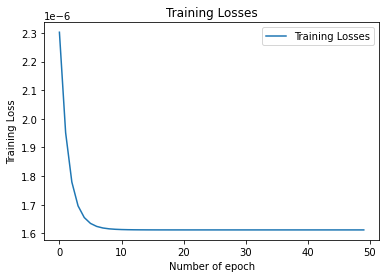

In [46]:
""# part a.plot.1
fig = plt.figure()
plt.plot(losses_train, label="Training Losses")
plt.title("Training Losses")
plt.legend()
plt.xlabel('Number of epoch')
plt.ylabel('Training Loss')
plt.show()

Doing predictions on the test set.

In [52]:
y_test, t_hat_test, loss_test, acc_test, grad = predict(X_test, W_best, t_test)

print('At epoch', epoch_best, 'val: ', acc_best, 'test:', acc_test)
print(f"The loss of best epoch with test data is  {loss_test:10.10f}")
print(f"The accuracy best epoch with test set is {acc_test:10.10f}")

At epoch 49 val:  0.82 test: 0.7843
The loss of best epoch with test data is  10.5465372016
The accuracy best epoch with test set is 0.7843000000


c:\users\nathan\pycharmprojects\cmput_466_coding_assignment_2\.venv\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


In [53]:

print(f"train accuracy:{getAccuracy(X_train, t_train, W_best)}")
print(f"validation accuracy:{getAccuracy(X_val, t_val, W_best)}")
print(f"test accuracy:{getAccuracy(X_test, t_test, W_best)}")

train accuracy:0.82016
validation accuracy:0.82
test accuracy:0.7843


c:\users\nathan\pycharmprojects\cmput_466_coding_assignment_2\.venv\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
